### Experiments with Zero Flip Angle Noise Measurements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mriqa.phantoms import phantom_mask_2d, find_phantom, SIEMENSLONGBOTTLE
from mriqa.dcmio import (
    fetch_series, rx_coil_name, approx_slice_orientation,
    approx_phase_orientation, series_number, seq_name, protocol_name,
    pix_spacing_yx
)
from mriqa.tools import mean_im, diff_im
from dcmextras.siemenscsa import csa, phoenix
import pandas as pd
import warnings

In the absence of anything better we can identify the coil element by a string in the image csa header `UsedChannelString`. These are of the form:
```
'X-------------------------------'
```
and we can get the element by searching for the `X`.

In [2]:
def coil_element(dobj):
    return csa(dobj, 'image')['UsedChannelString'].index('X')

Fetch the series from the DICOM server and sort according to coil element. We assume for now that there is just a single slice.

In [3]:
# Study details (9/sept/2016)
patid = 'PQA20160906RHD'
stuid = '1'

# Last acquired series high resolution, low bandwidth
sernos = [16]
dobjs = sorted(fetch_series(patid, stuid, sernos), key=coil_element)

Check some sequence parameters.

In [4]:
nobjs = len(dobjs)
print('Images    = %d' % nobjs)
# Acquisition parameters
d = dobjs[0]
print('TR/TE     = %d / %d ms' % (d.RepetitionTime, d.EchoTime))
print('Matrix    = %d x %d'    % (d.Rows, d.Columns))
print('Sequence  = %s'         % d.SequenceName)
print('FoV       = %d x %d mm' % (d.Rows * d.PixelSpacing[0], d.Columns * d.PixelSpacing[1]))
print('Bandwidth = %d Hz'      % d.PixelBandwidth)
print('Phase Enc.= %s'         % d.InPlanePhaseEncodingDirection)

Images    = 32
TR/TE     = 100 / 55 ms
Matrix    = 1024 x 1024
Sequence  = *se2d1
FoV       = 500 x 500 mm
Bandwidth = 20 Hz
Phase Enc.= COL


In [5]:
elements = [coil_element(d) for d in dobjs]
nelements = len(elements)
print('Elements: %s (%d)' % (elements, nelements))
assert nelements == nobjs

Elements: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] (32)


In [6]:
def show_coil_mosaic(dobjs, cmap=None):
    '''Display a list of dicom coil element images as a mosaic

       dobjs : Sequence of dicom objects to display
       cmap : Optional colour map
    '''
    images = [d.pixel_array & 0xfff for d in dobjs]

    nimages = len(images)
    nx = int(round(np.sqrt(nimages)))
    ny = int(np.ceil(nimages / nx))
    if nx == 0 or ny == 0:
        nx = ny = 1
    fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
    try:
        axs[0]
    except (TypeError, IndexError):
        axs = np.asarray([axs]).reshape((1, 1))

    vmax = 0.75 * np.asarray(images).max()
    
    for i, image in enumerate(images):
        axs[i // nx, i % nx].imshow(image, vmin=0, vmax=vmax, cmap=cmap)
        axs[i // nx, i % nx].axis('image')
        axs[i // nx, i % nx].axis('off')
        axs[i // nx, i % nx].set_title('Element %d' % (coil_element(dobjs[i])+1))

    if nimages < nx*ny:
        # pad out grid
        for i in range(nimages, nx*ny):
            axs[i // nx, i % nx].imshow(np.zeros_like(images[0]), cmap=cmap)
            axs[i // nx, i % nx].axis('image')
            axs[i // nx, i % nx].axis('off')
    return

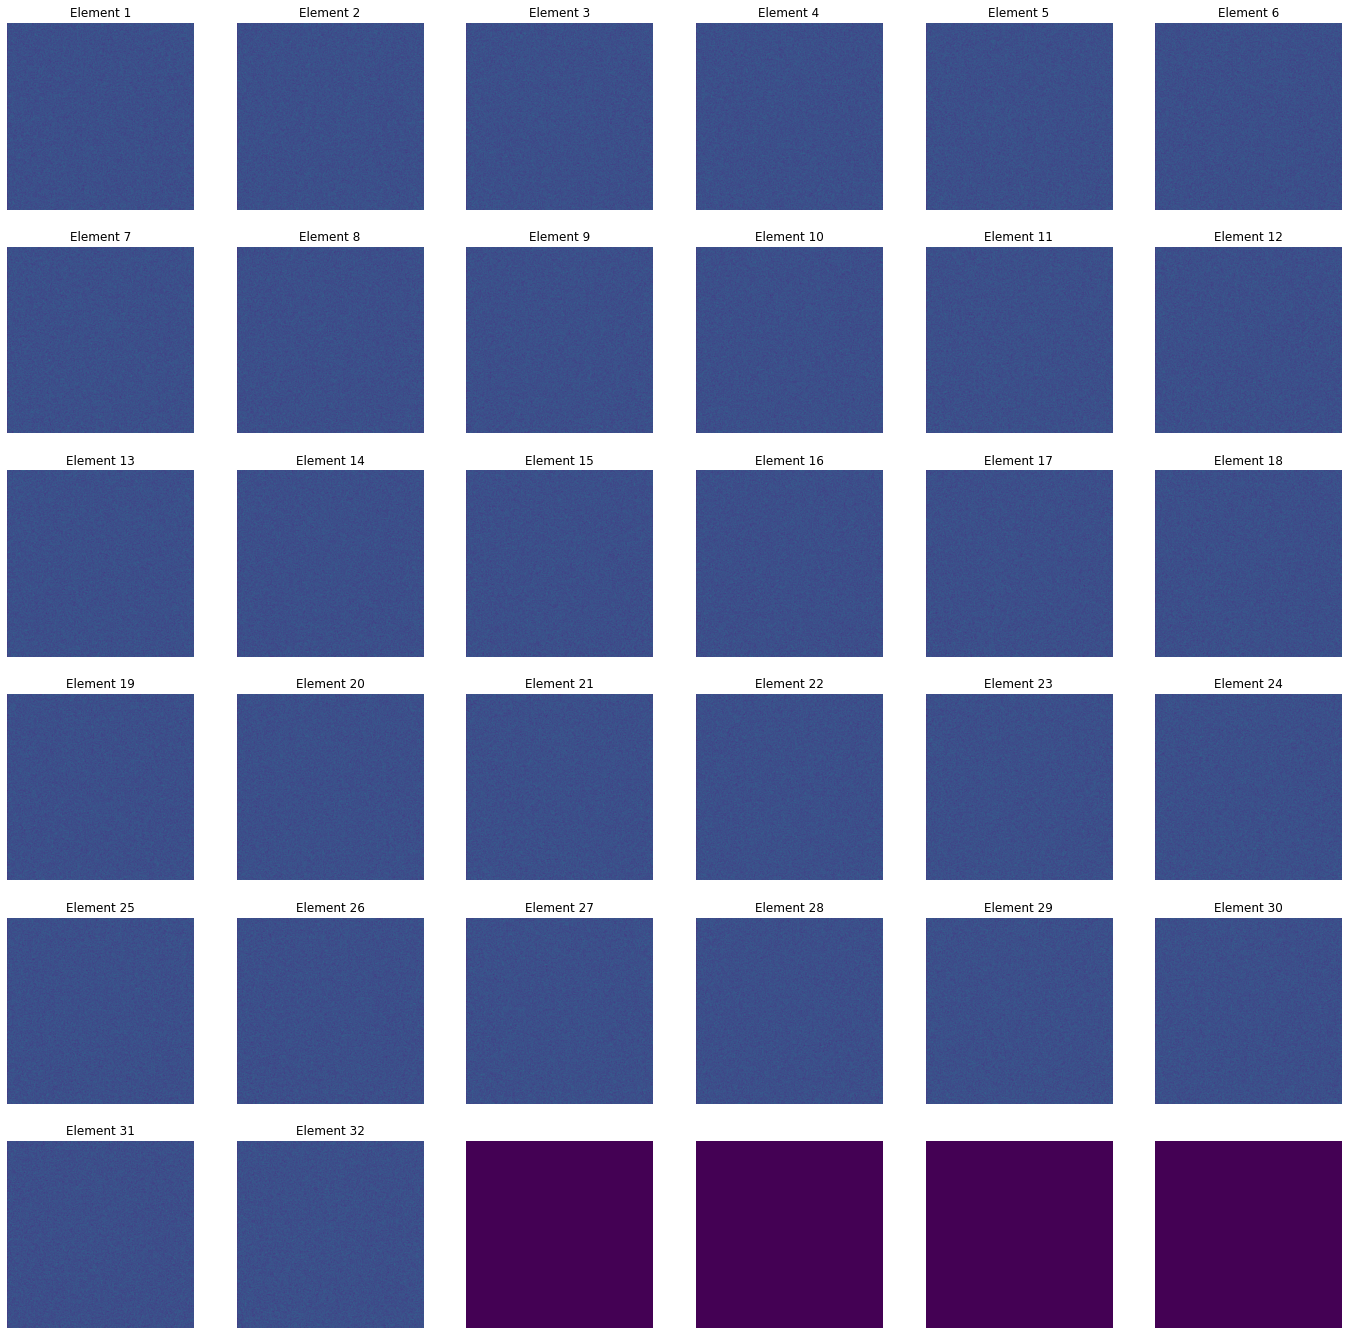

In [7]:
show_coil_mosaic(dobjs, cmap='viridis')

Input Shape: (32, 1048576)
Covariance shape: (32, 32)
Range: 0.3098452155550935 867.8073952771603


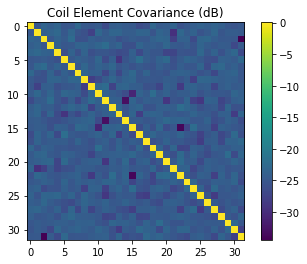

In [8]:
imstack = np.array([
    d.pixel_array for d in dobjs
])
imstack = imstack.reshape(len(imstack), -1)

print('Input Shape:', imstack.shape)
covariance = np.cov(imstack)
print('Covariance shape:', covariance.shape)
assert covariance.shape == (nelements, nelements)

print('Range:', np.amin(covariance), np.amax(covariance))
norm = np.mean(np.diag(covariance))
plt.imshow(10*np.log10(covariance/norm), cmap='viridis', interpolation='nearest')
plt.grid(False)
plt.title('Coil Element Covariance (dB)')
plt.colorbar();

In [9]:
on_diagonal_mean = np.trace(covariance) / nelements
off_diagonal_mean = (np.sum(covariance) - np.trace(covariance)) / (nelements * (nelements - 1))
print('On Diagonal Mean:', on_diagonal_mean)
print('Off Diagonal Mean:', off_diagonal_mean)                                                                                                                                                                                                                                                                         
print('Mean off axis Contribution of %d dB' % [10 * np.log10(off_diagonal_mean / on_diagonal_mean)][0])

covariance_tmp = covariance.copy()
np.fill_diagonal(covariance_tmp, 0)
off_diagonal_max = np.max(covariance_tmp)

print('Off Diagonal Max:', off_diagonal_max)                                                                                                                                                                                                                                                                         
print('Max off axis Contribution of %d dB' % [10 * np.log10(off_diagonal_max / on_diagonal_mean)][0])

On Diagonal Mean: 858.9272825114358
Off Diagonal Mean: 3.0295362603942597
Mean off axis Contribution of -24 dB
Off Diagonal Max: 5.438548753470693
Max off axis Contribution of -21 dB


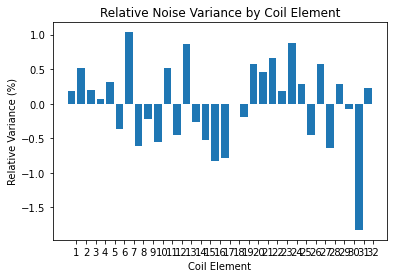

In [10]:
fig, ax = plt.subplots(1, 1)
inds = np.arange(nelements)
onaxis = np.diagonal(covariance)
onaxis_norm = (onaxis - onaxis.mean()) / onaxis.mean() * 100
ax.bar(inds, onaxis_norm)
ax.set_xticks(inds + 0.5)
ax.set_xticklabels(map(str, inds +1))
ax.set_title('Relative Noise Variance by Coil Element')
ax.set_xlabel('Coil Element')
ax.set_ylabel('Relative Variance (%)')

ax.axis('tight');

Strange. There is definitely a difference in the brightness of the noise images between coil elements but the values of the variance on the diagonal of the co-variance matrix seem almost constant. Is this expected? Check the means. Ah, it was just a display artefact.

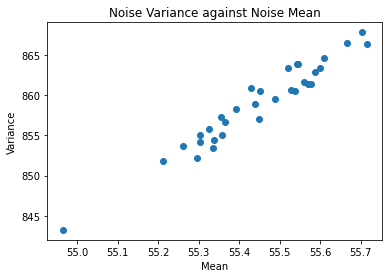

In [11]:
means = imstack.mean(axis=1)
variances = imstack.var(axis=1)

plt.scatter(means, variances)
plt.xlabel('Mean')
plt.ylabel('Variance')

plt.title('Noise Variance against Noise Mean');

OK, that looks fine. We do in fact expect some variation in the noise from element to element as the coil elements will have different sensitive volumes and so as far as the component of the noise from the phantom is concerned they will see slightly different noise powers.

To do SNR maps we need images with a 90&deg; flip as well, keeping everything else the same. The protocol used here is not very realistic though. We minimised the bandwidth etc to keep the receive gate open for as long as possible. We should redo this with a more realistic acquisition protocol. It can still be a compromise - we could use a bandwidth of say 130Hz or 65Hz.

There is also the issue of the image scaling. So as not to drop into the bit noise floor we had too put an image scaling in of around 100 (and used the 'high' sensitivity setting). We wouldn't want to do this for the signal image or we might overflow. Need to check what we can get away with. We may have to assume that the scaling factor propagates simply into the noise values.